### Imports

In [1]:
import pyedflib
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from imp import reload
import pandas as pd
import pywt
import readFiles
import databasePreparation
import preProcessing
import math
from scipy import ndimage, misc
import json
import string

from visualization import plotEogElectrodesSignal, plotVertHorEOG
from classificationUtils import peaksToBinary, peaksBinaryToString, countEyeMovements

### Reading Data

The data is read from an edf file, the EOG channels are extracted and the file is closed.

The edf file contains 272 channels, from all those channels, we are only interested in 4 of them:


| Channel Number | Channel Name | EOG Electrode |
| :---: | :------: | :------------------: |
| 256 | EXG1 | Left Electrode |
| 257 | EXG2 | Right Electrode |
| 258 | EXG3 | Down Electrode |
| 259 | EXG4 | Up Electrode |

In [2]:
# Reading the signals from the EDF file

edfFileName = 'C:/Users/Ricardo\source/enac-eog-analysis/data/EOG_EyeLink/RI02/Testdata0602.edf'
eyesData = readFiles.readEog(edfFileName)

freqSample = 2048

In [3]:
labelsCsvFile = 'C:/Users/Ricardo\source/enac-eog-analysis/data/EOG_EyeLink/RI02/labels_triggers_602.csv'

triggerCsv = readFiles.readCsvTriggerLabels(labelsCsvFile)

### Pre Processing

This section of the code is for signal processing like **noise filtering** and **baseline drift/wandering removal**.

For **baseline drift mitigation**, we used:
1. Scipy Detrend Function
2. 10th order Butterworth high-pass filter with optimal cut-off frequency described in literature: 0.04Hz

**Note:** The high-pass is useful for real time applications.

**Note:** The signal needs to be checked for baseline drift, because if it doesn't have it, then it is **unnecessary** to apply baseline drift mitigation.

In [4]:
# Pre-processing of the signal using butterworth filter
sos = signal.butter(10, 10, 'lp', fs=freqSample, output='sos')
eyesDataFiltered = signal.sosfilt(sos, eyesData)


In [5]:
# Pre-processing: baseline wandering/drift mitigation
eyesDataFiltered2 = signal.detrend(eyesDataFiltered)

In [6]:
# Pre-processing: baseline wandering/drift mitigation
sos2 = signal.butter(1, 0.04, 'highpass', fs=freqSample, output='sos')
eyesDataFiltered3 = signal.sosfilt(sos2, eyesDataFiltered)

### Ploting Example

Part of the electrode's signals that corresponds to calibration.

1. First example: The electrode signals with **baseline wandering removal using python detrend**

2. Second example: The electrode signals with **baseline wandering removal using high-pass butter filter**

3. Third example: The electrode signal **with out any kind of filtering**

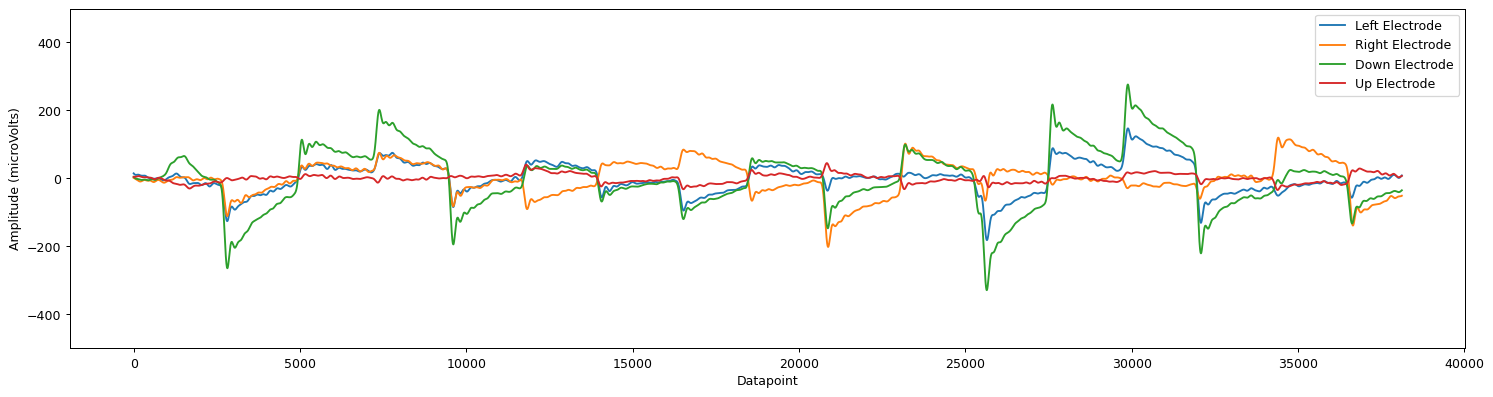

In [7]:
calibrationPart = databasePreparation.getEogCalibrationPart(eyesDataFiltered2, triggerCsv)
calibrationPart = signal.detrend(calibrationPart)
labels = ['Left Electrode', 'Right Electrode', 'Down Electrode', 'Up Electrode']
plotEogElectrodesSignal(calibrationPart, labels=labels)

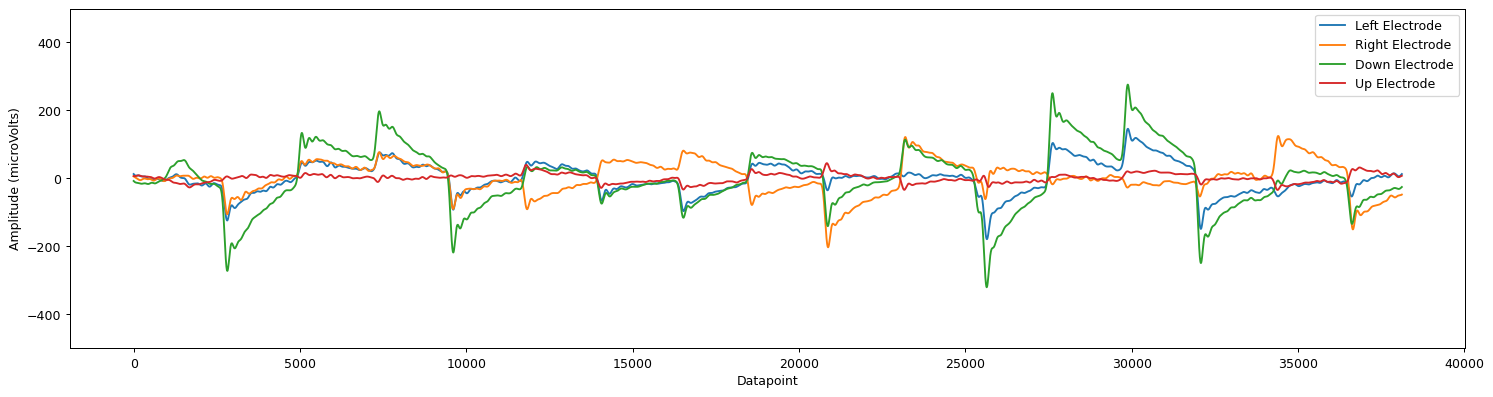

In [8]:
calibrationPart2 = databasePreparation.getEogCalibrationPart(eyesDataFiltered3, triggerCsv)
labels = ['Left Electrode', 'Right Electrode', 'Down Electrode', 'Up Electrode']
plotEogElectrodesSignal(calibrationPart2, labels=labels)

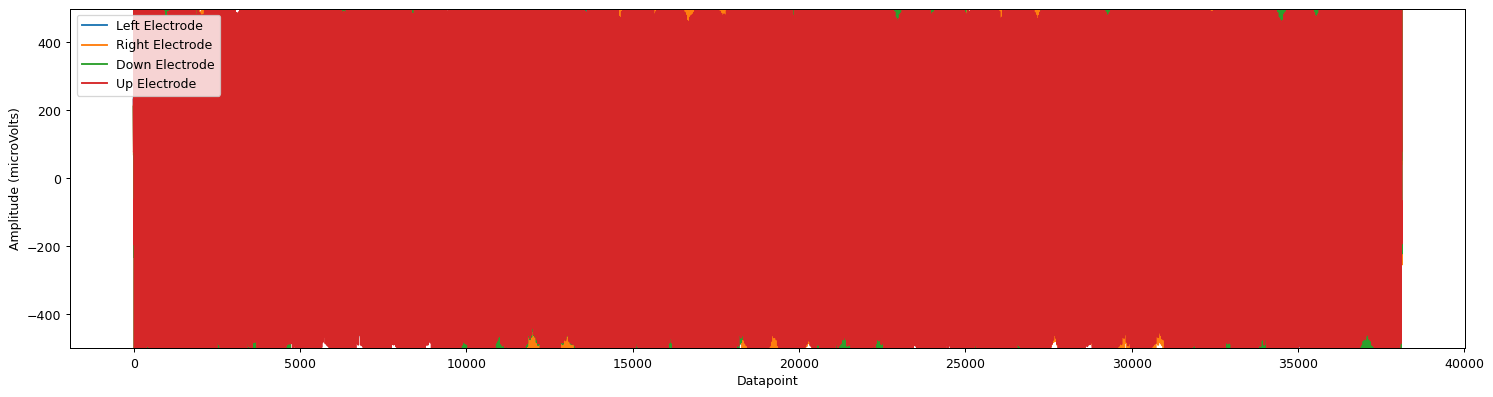

In [9]:
calibrationNoPreprocessing = databasePreparation.getEogCalibrationPart(eyesData, triggerCsv)
labels = ['Left Electrode', 'Right Electrode', 'Down Electrode', 'Up Electrode']
plotEogElectrodesSignal(calibrationNoPreprocessing, labels=labels)

# Subtracting the signals

To analyze the signal, we must subtract the potencials from the Up and Down Electrode and the Left and Right Electrode.

The first plot corresponds to the signal subtraction without desnoising the signal beforehand.

The second plot corresponds to the denoising of the previous signal

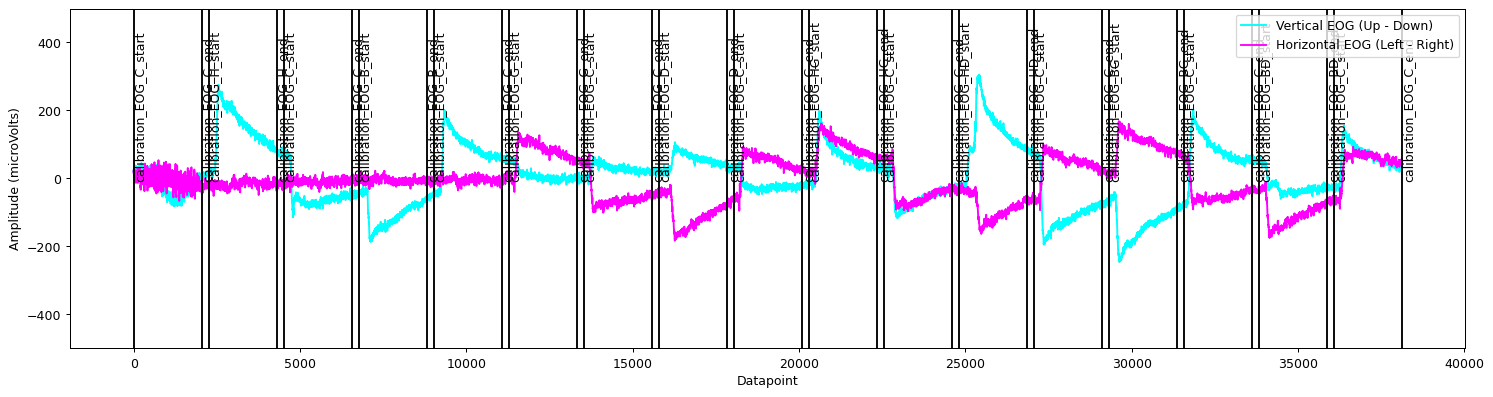

In [10]:

verticalEOG, horizontalEOG = preProcessing.electrodesToVertHori(calibrationNoPreprocessing, 0, 1, 2, 3)
calStartArray, calEndArray = databasePreparation.getEogLabelIndexes(triggerCsv, 'calibration_EOG_C_start', 'calibration_EOG_C_end')
calibrationStart = calStartArray[0]
calibrationEnd = calEndArray[-1]
    
plotVertHorEOG(verticalEOG, horizontalEOG, triggerStart=calibrationStart, triggerEnd=calibrationEnd,  mode='both', triggerCsv=triggerCsv)


### Reading .csv file with the labels for the triggers. 
These triggers represent the start and the end points of parts of the experiment.

In the following table, it is explained the meaning of each trigger.

| Meaningful Labels  | Description |
| :----------------: | :----------------: |
| **calibration_EOG_C_start** | Start of a calibration movement in a certain direction |
| C, H, B, G, D | Center, Haut, Bas, Gauche, Droite |
| calibration_EOG_C_end | End of a calibration movement |
| S_CF_start | Start of Cross Fixation (CF) for the Semantic (S) Questions round |
| S\_Q\_start\_&\_CF\_end | Start of Semantic (S) Question and Cross Fixation (CF) end |
| S_L_start or S_L_end | Analysis of letter's roundness by subject (8 or more of these in a row) |
| **S_access** | Subject acesses memories to answer previous question |
| **S_visualization** | Time to recall more details of that memory in order to answer it better |
| S_debriefing | Subject answers question. (Very noisy) |
| S, A, V | Semantic, Autobiographical, Visual Task |
| V_image | Subject analyses image to defrief it afterwards, instead of acess and visualization |

The labels in **bold** are the ones that are the most important for this eye movement project.

# Saccade Detection

This section is dedicated to using several algorithms for saccade detection:
1. Continuous Wavelet Transform - Saccade Detection based on article: Eye Movement Analysis for Activity Recognition Using Electrooculography
2. Velocity based approaches


### CWT-SD Mexican Hat Wavelet

### Peak Finder

In this section the peaks of the extracted signal in the previous section are extracted to decode the saccades and their duration!

In [11]:
savParts = databasePreparation.getEogSAVParts(eyesData, triggerCsv)
semanticParts = savParts[0]
autobioParts = savParts[1]
visualParts = savParts[2]

In [29]:
#for i,part in enumerate(visualParts):
verticalEOG, horizontalEOG = preProcessing.electrodesToVertHori(semanticParts[2], 0, 1, 2, 3)

verticalEogDenoised = ndimage.median_filter(verticalEOG, size = 200)
horizontalEogDenoised = ndimage.median_filter(horizontalEOG, size = 200)

# sos = signal.butter(10, [5, 10], 'bandstop', fs=freqSample, output='sos')
# verticalEogDenoisedF = signal.sosfilt(sos, verticalEogDenoised)
# horizontalEogDenoisedF = signal.sosfilt(sos, horizontalEogDenoised)

verticalEOG = verticalEogDenoised
horizontalEOG = horizontalEogDenoised

coefVertMexHat, freqsVertMexHat = pywt.cwt(verticalEOG, 30, 'mexh')
coefHoriMexHat, freqsHoriMexHat = pywt.cwt(horizontalEOG, 30, 'mexh')

coefVertMexHat1 = np.reshape(coefVertMexHat, (len(coefVertMexHat[0]),1))
coefHoriMexHat1 = np.reshape(coefHoriMexHat, (len(coefHoriMexHat[0]),1))

#coefVertMexHat2 = preProcessing.zeroPadArtifacts(coefVertMexHat1, 70)

# Peakfinding

# Flatten the vectors so they can be used in the signal.find_peaks function
vertCwt = coefVertMexHat1.flatten()
horiCwt = coefHoriMexHat1.flatten()

# Thresholds of the saccade peaks
peaksHeight = np.array([90, 600])
minSaccadeDistance = 20

# Returns peaks' indexes and their properties in a dict
# The peaks are detected in the module version of signal in order to find the negative peaks as well
peaksV, propertiesV = signal.find_peaks(abs(vertCwt), height=peaksHeight, distance=minSaccadeDistance)
peaksH, propertiesH = signal.find_peaks(abs(horiCwt), height=peaksHeight, distance=minSaccadeDistance)

a = np.hstack((peaksV,peaksH))
print(a)
a = np.sort(a)
print(a)

print(a.shape)
print(peaksV.shape)
print(peaksH.shape)
# vertPeaksBinary = peaksToBinary(peaksV, vertCwt)
# horiPeaksBinary = peaksToBinary(peaksH, horiCwt)

# # Detecting saccades candidates and blink candidates
# vertPeaksString = peaksBinaryToString(vertPeaksBinary)
# horiPeaksString = peaksBinaryToString(horiPeaksBinary)

# up, down, left, right, blinks = countEyeMovements(vertPeaksString, horiPeaksString)

# fileName = "Testdata0602"
# partName = "visual{}".format(i+1)
# plotName = "{}_{}".format(fileName, partName)

# infoDict = {"name": plotName,
#             "wavelet": "Mexican Hat",
#             "scale": "30",
#             "lowThreshold": str(peaksHeight[0]),
#             "highThreshold": str(peaksHeight[1]),
#             "upSaccadeCount": str(up),
#             "downSaccadeCount": str(down),
#             "leftSaccadeCount": str(left),
#             "rightSaccadeCount": str(right),
#             "blinkCount": str(blinks)}

# infoJson = json.dumps(infoDict, indent=3)

# with open("{}_info.json".format(plotName), "w") as outfile: 
#     outfile.write(infoJson) 

# print('Part Name: {}\n'.format(plotName))
# print('Wavelet: Mexican Hat \nScale: 30\nPeak Threshold: {}'.format(peaksHeight))
# print('\n(\'0110\') Upward Saccade Count: {}\n(\'1001\') Downward Saccade Count: {}\n(\'0110\') Right Saccade Count: {}\n(\'1001\') Left Saccade Count: {}\n(\'010\') Blink Count: {}'.format(up,down,left,right,blinks))

# # All the plots

# plotVertHorEOG(verticalEogDenoised, horizontalEogDenoised,  mode='both')
# plt.savefig('{}_eog.png'.format(plotName))
# plt.show()

# plt.figure(figsize=(20, 5), dpi=90)
# plt.plot(coefVertMexHat1, color='black', linestyle=':')
# plt.plot(peaksV, coefVertMexHat1[peaksV], "x", color='red')
# plt.plot(verticalEOG, color='cyan')
# plt.ylim(-500,500)
# plt.xlabel('Datapoint')
# plt.ylabel('Amplitude (mV)')
# labels = ['Vertical EOG Wavelet Transform', 'Transform Peaks', 'Vertical EOG']
# plt.legend(labels)
# plt.savefig('{}_eogVTransform.png'.format(plotName))
# plt.show()

# plt.figure(figsize=(20, 5), dpi=90)
# plt.plot(coefHoriMexHat1, color='black', linestyle=':')
# plt.plot(peaksH, coefHoriMexHat1[peaksH], "x", color='red')
# plt.plot(horizontalEOG, color='magenta')
# plt.ylim(-500,500)
# plt.xlabel('Datapoint')
# plt.ylabel('Amplitude (mV)')
# labels = ['Horizontal EOG Wavelet Transform', 'Transform Peaks', 'Horizontal EOG']
# plt.legend(labels)
# plt.savefig('{}_eogHTransform.png'.format(plotName))
# plt.show()

[ 4867  4933  5060  5141  6680  6755  9098  9203 13152 13358 13536 13672
 13797 19074 19204 19302 19444 21245 21270 21451 21530 21569 21590 22240
  6197  6344  8005  8750]
[ 4867  4933  5060  5141  6197  6344  6680  6755  8005  8750  9098  9203
 13152 13358 13536 13672 13797 19074 19204 19302 19444 21245 21270 21451
 21530 21569 21590 22240]
(28,)
(24,)
(4,)


### CWT-SD Custom Haar Mother Wavelet

In one of the articles that use this approach, haar mother wavelet is used for the CWT in order to detect saccades and blinks.

Unfortunetly, I didn't manage to implement that approach just yet.

### Velocity Acceleration Approach

There are a few articles about this method as well, need to see if it works later.

### Video and EOG Synchronization

The data used in the project is recorded in three different ways: EOG signal, Eye Tracking and Video Recording.
For checking this algorithm in a informal way, we will try to synchronize the video recording and the EOG signal.

